# High Plains Aquifer Potentiometric Surface

This week, we are going to create a potentiometric surface for a heavily stressed portion of the High Plains Aquifer system in southwestern Kansas. 

### Import packages

This week, we are going to use four libraries that you have already seen (pandas, matplotlib, pylab, and numpy).

We are also going to use a new package, CartoPy, to do mapping. In CoLab, we can import our packages in a code cell. If you are using your own version of Anaconda, in Conda Prompt, run "conda install cartopy" before running this script. Next, we are going to import the pykrige package, which we much install. In Conda Prompt, run "pip install pykrige". This will add pykrige to your Anaconda installation . We are going to import the Universal Kriging function to make contours.

In [11]:
# CoLab recommends to run the following two lines of code to import cartopy. 
#You will likely need to reinstall each time you log into CoLab, but it doesn't take too long. 
#You can keep running this even after installed, because it will recognize the install quickly.
!apt-get -qq install python-cartopy python3-cartopy
import cartopy

# And here we install pykrige. Note that this differs from a normal pip install in that it requires a leading "!"
!pip install pykrige

### Import packages

You have already seen pandas and matplotlib. We also need to import cartopy and pykrige (the above lines of code only installed them for use in Python but they still need imported to run in this notebook). Finally, we are going to import pylab (which is used for plotting spatial images) and numpy (which is used to work with spatial data).

In [0]:
# Now let's import packages
import pandas as pd
import matplotlib.pyplot as plt
import pylab  # using as a plotting library for spatial data (looking at the contours)
import numpy as np # array package 

# import cartopy, which we will use to map
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features


# import the UniversalKriging function from pykrige.uk 
from pykrige.uk import UniversalKriging

### Import data from the High Plains aquifer

This data is from 2013 (pre-irrigation season) for the High Plains Aquifer. We are going to work with data from the southern portion of Kansas and northern Texas, where water level changes are most extreme. We also calculate head and remove erroneous values where the land surface shows as 0 ft. 

![HighPlains](https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/full_width/public/thumbnails/image/hp_wlcpd15go.png)

In [14]:
# High Plains aquifer data from Kansas, import into dataframe
hp_dtw = pd.read_excel('https://github.com/dbabrams/Week6PotSurface/blob/master/DTW_1995.xlsx?raw=true')

# add a column for head and calculate as (land surface - depth to water)
# hp_dtw = hp_dtw.join(pd.DataFrame({'heads_ft': hp_dtw['land_surface']-hp_dtw['DTW']}))
hp_dtw['heads_ft']=hp_dtw['land_surface']-hp_dtw['DTW']
print(hp_dtw)
# remove rows where land surface is not known and shows as 0 ft
hp_dtw = hp_dtw.drop(hp_dtw[hp_dtw['land_surface'] == 0].index)

         site_name     lat_dd     long_dd  land_surface     DTW  heads_ft
0     HP-01-40-301  36.493359 -103.039652        4702.0  147.72   4554.28
1     HP-01-40-902  36.408084 -103.037431        4690.0  127.10   4562.90
2     HP-01-56-301  36.240865 -103.032154        4570.0  152.41   4417.59
3     HP-01-56-602  36.196144 -103.030210        4523.0  164.33   4358.67
4     HP-01-64-301  36.119756 -103.001598        4439.0  124.50   4314.50
...            ...        ...         ...           ...     ...       ...
7483  39N33W15DDDD  43.345556 -101.198204        2800.0   35.30   2764.70
7484  39N41W17CBBB  43.353047 -102.208769        3067.0   38.80   3028.20
7485  39N32W 3AAAA  43.388891 -101.078480        2610.0   31.70   2578.30
7486  40N32W32BBBB  43.403335 -101.137369        2640.0   21.90   2618.10
7487  40N32W21BBBB  43.432501 -101.117924        2576.0    6.70   2569.30

[7488 rows x 6 columns]


We don't want to work with all of the data, so let's trim to the southern portion of Kansas and northern portion of Texas where head declines are at their greatest. 

In [0]:
# define the area over which to plot data
minlat = 35
maxlat = 38.2
minlong = -101.75
maxlong = -100.10

# trim the dataset
hp_dtw = hp_dtw.drop(hp_dtw[hp_dtw['lat_dd'] < minlat].index)
hp_dtw = hp_dtw.drop(hp_dtw[hp_dtw['lat_dd'] > maxlat].index)
hp_dtw = hp_dtw.drop(hp_dtw[hp_dtw['long_dd'] < minlong].index)
hp_dtw = hp_dtw.drop(hp_dtw[hp_dtw['long_dd'] > maxlong].index)

### Conduct kriging

After importing the pykrige package, conduct a Universal Kriging. The Universal Kriging function requires the following input parameters:

<ul>
    <li>The longitude of points to be interpolated, as a numpy data array</li>
    <li>The latitude of points to be interpolated, as a numpy data array</li>
    <li>Head for each point</li>
    <li>Variogram model, assigned as "Spherical". We could also explore Gaussian, Linear, Exponential, etc.</li>
    <li>"nlags" indicate how many points are binned when conducting the interpolation.</li>
</ul>

In [17]:
# conduct the Universal Kriging, note that the output is an object that we have to work with later. 
UK = UniversalKriging(hp_dtw['long_dd'], hp_dtw['lat_dd'], hp_dtw['heads_ft'], variogram_model='spherical',nlags=6)
print(UK)  # UK is an UniversalKriging object

### Create a grid to plot the data

![int](http://www.bisolutions.us/web/graphic/spacial_interpolation_001.gif)

First, we need to define the range over which we are going to create out plot (xpoints and ypoints are the "input" in the above image). Second, we need to create the x and y coordinates for the grid (with a grid spacing of 0.01). We do this by defining the x and y points for each grid cell, defined as X and Y. Coarse grid spacing will result in faster run times. Finally, we use the method UK.execute(), with arguments that first inform that we are creating a grid ('grid'), xpoints, and ypoints. The output of this method is the interpolated values and the variance. Note that we also run the method z.filled(), which will fill in any missing values. We assign the fill_value as 'None'. This code returns the output shown above.

In [20]:
# create xpoints and ypoints in space, with 0.01 spacing
xpoints = np.arange(minlong,maxlong,0.01)
ypoints = np.arange(minlat,maxlat,0.01)

# create a meshgrid with xpoints and ypoints, to be used later in the code
X,Y = np.meshgrid(xpoints,ypoints)

# calculate the interpolated grid and fill values.
z, var = UK.execute('grid', xpoints,ypoints)
z = z.filled(fill_value=None)
print(z)

[[3319.22617298 3319.33198954 3319.18574215 ... 2605.9839383
  2605.58101034 2605.24610816]
 [3322.14484091 3322.37637443 3322.34086868 ... 2603.10648185
  2602.71719732 2602.39482999]
 [3325.03697241 3325.40896189 3325.49399812 ... 2600.17002005
  2599.79292182 2599.48448043]
 ...
 [3182.1985565  3183.03361548 3183.82296482 ... 2620.40217494
  2619.51195312 2618.6987932 ]
 [3181.23199425 3182.04798478 3182.8156174  ... 2622.84978232
  2621.92798135 2621.08273529]
 [3180.15058969 3180.93910961 3181.67693038 ... 2625.33128919
  2624.38124194 2623.50659711]]


### Create a potentiometric surface

Let's create a map using CartoPy with the defined extents and imported data, as well as the interpolated grid from above. We will need to use the following arguments:

<ul>
    <li>mesh grid X</li>
    <li>mesh grid Y</li>
    <li>Interpolated grid z</li>
    <li>Range over which to contour (2000-3000 ft works well, with an interval of 100 ft)</li>
</ul>

Next, we will label the contours using pylab.clabel, with the following arguments:

<ul>
    <li>The object defining the contours </li>
    <li>inline, which defines how labels are positioned</li>
    <li>font size</li>
    <li>label format (here we format as an integer using fmt = '%1.0f')</li>
</ul>

/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/cultural/ne_10m_urban_areas.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_rivers_lake_centerlines.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_rivers_lake_centerlines_scale_rank.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/lib/python3/dist-packages/cartopy/io/__init__.py:264: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


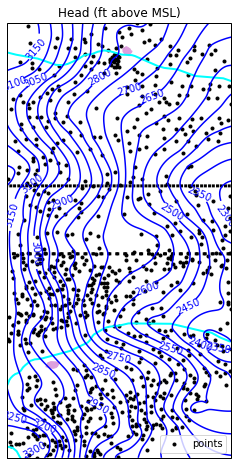

In [21]:
# Create a figure
fig = plt.figure(figsize=(8, 8))
# define a projection
ax = plt.axes(projection=ccrs.PlateCarree())
# define spatial domain to plot
ax.set_xlim(minlong,maxlong)
ax.set_ylim(minlat,maxlat)
# define title
ax.set_title("Head (ft above MSL)")

# we are now going to use CartoPy to import a number of features from Natural Earth Data
# Visit https://www.naturalearthdata.com/features/ for more options
states_provinces = cf.NaturalEarthFeature(
    category='cultural', # features are categorized as cultural or physical
    name='admin_1_states_provinces', # name of shapefile
    scale='50m', # scale of features
    facecolor='none')	
largerivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='110m', # major rivers
    facecolor='none')
smallrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines_scale_rank',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')   
popplaces = cf.NaturalEarthFeature(
    category='cultural',
    name='urban_areas', # plots municipal boundaries
    scale='10m',
    facecolor='plum') 
# adds the features defined above
ax.add_feature(popplaces,edgecolor='plum',linewidth=1.0)
ax.add_feature(largerivers,edgecolor='aqua',linewidth=2.0)
ax.add_feature(smallrivers,edgecolor='aqua',linewidth=2.0)
ax.add_feature(states_provinces, edgecolor='black', linewidth=3.0,linestyle=':')

# create contours from the interpolation
cset = plt.contour(X,Y,z,np.arange(1000, 5000, 50),colors='blue')

# labels contours, makes use of pylab
pylab.clabel(cset, inline=1, fontsize=10,fmt='%1.0f')

# plot the points that were measured
plt.scatter(hp_dtw['long_dd'], hp_dtw['lat_dd'], marker=".", color="black", label="points")
plt.legend(loc='lower right')
plt.title('Head (ft above MSL)')
plt.show()


Let's define two functions, the first to create the interpolated grid and the second to plot it. With minor variations, this is the same code that we worked with above. 

In [0]:
def HighPlains(xlsx_file,minlat,maxlat,minlong,maxlong,nlags):
  df = pd.read_excel(xlsx_file)
  df = df.join(pd.DataFrame({'heads_ft': df['land_surface']-df['DTW']}))
  df = df.drop(df[df['land_surface'] == 0].index)
  df = df.drop(df[df['lat_dd'] < minlat].index)
  df = df.drop(df[df['lat_dd'] > maxlat].index)
  df = df.drop(df[df['long_dd'] < minlong].index)
  df = df.drop(df[df['long_dd'] > maxlong].index)
  UK = UniversalKriging(df['long_dd'], df['lat_dd'], df['heads_ft'], variogram_model='spherical',nlags=nlags)
  # create xpoints and ypoints in space, with 0.01 spacing
  xpoints = np.arange(minlong,maxlong,0.01)
  ypoints = np.arange(minlat,maxlat,0.01)
  # create a meshgrid with xpoints and ypoints, to be used later in the code
  X,Y = np.meshgrid(xpoints,ypoints)
  # calculate the interpolated grid and fill values.
  z, var = UK.execute('grid', xpoints,ypoints)
  z = z.filled(fill_value=None)
  return X, Y, z
  
def hydrograph_plotter(X, Y, z, mincon, maxcon, invcon, title):  
  # insert figure
  fig = plt.figure(figsize=(8, 8))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.set_title("Head (ft above MSL)")
  states_provinces = cf.NaturalEarthFeature(
      category='cultural',
      name='admin_1_states_provinces',
      scale='50m',
      facecolor='none')	
  largerivers = cf.NaturalEarthFeature(
      category='physical',
      name='rivers_lake_centerlines',
      scale='110m',
      facecolor='none')
  smallrivers = cf.NaturalEarthFeature(
      category='physical',
      name='rivers_lake_centerlines_scale_rank',
      scale='10m',
      facecolor='none')   
  popplaces = cf.NaturalEarthFeature(
      category='cultural',
      name='urban_areas',
      scale='10m',
      facecolor='plum') 
  ax.add_feature(popplaces,edgecolor='plum',linewidth=1.0)
  ax.add_feature(largerivers,edgecolor='aqua',linewidth=2.0)
  ax.add_feature(smallrivers,edgecolor='aqua',linewidth=2.0)
  ax.add_feature(states_provinces, edgecolor='black', linewidth=3.0,linestyle=':')
  # create contours from the interpolation
  cset = plt.contour(X,Y,z,np.arange(mincon, maxcon, invcon),colors='blue')
  # contour labels
  pylab.clabel(cset, inline=1, fontsize=10,fmt='%1.0f')
  plt.title(title)
  plt.show()


Now let's import data from 1995 and 2013. This will take some time to run. 

In [0]:
# High Plains aquifer data from Kansas, import into dataframe
dtw_1995 = 'https://github.com/dbabrams/Week6PotSurface/blob/master/DTW_1995.xlsx?raw=true'
dtw_2013 = 'https://github.com/dbabrams/Week6PotSurface/blob/master/DTW_2013.xlsx?raw=true'
# define the area over which to plot data
minlat = 35
maxlat = 38.2
minlong = -101.75
maxlong = -100.10
nlags = 6

X_95, Y_95, z_95 = HighPlains(dtw_1995,minlat,maxlat,minlong,maxlong,nlags)
X_13, Y_13, z_13 = HighPlains(dtw_2013,minlat,maxlat,minlong,maxlong,nlags)



Finally, let's plot the data. The last plot will show the head difference from 1995 to 2013. 

In [0]:
hydrograph_plotter(X_95, Y_95, z_95, 1000, 5000, 100,'Head (ft AMSL), 1995')
hydrograph_plotter(X_13, Y_13, z_13, 1000, 5000, 100,'Head (ft AMSL) 2013')
hydrograph_plotter(X_95, Y_95, z_95-z_13, -200, 200, 50,'Head Difference (1995 to 2013)')